<a href="https://colab.research.google.com/github/hyeonjun/AlphaZero/blob/master/6_3_MonteCarlo_Tree_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 알파제로의 몬테카를로 트리 검색

* 선택

이전에는 UCB1을 사용하여 루트 노드로부터 리프 노드에 도달할 때까지 UCB1이 가장 큰 자식 노드를 선택하는 방법으로 수를 진행했다. 알파제로에서는 UCB1이 아닌 '아크 평갓값'을 사용한다.

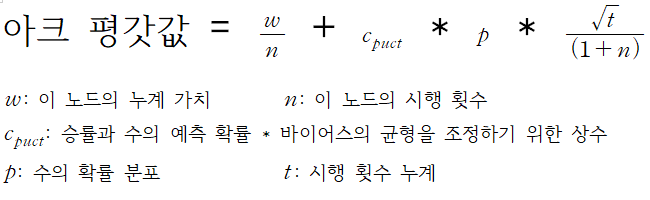

* 평가

이전에는 리프 노드에 도달했을 때 플레이아웃으로 가치를 취득했다. 알파제로에서는 플레이아웃이 아닌 뉴럴 네트워크에서 정책과 가치를 취득한다.

정책은 아크 평갓값의 계산, 가치는 누계 가치의 갱신에 이용한다.

* 전개

이전에는 노드의 시행 횟수가 10회 이상이 되면 전개를 수행해 자식 노드를 생성했다. 알파제로에서는 1회 이상이 된다. 뉴럴 네트워크를 사용하기 때문에 여러 차례 시뮬레이션을 수행하지 않아도 어느 수가 유효한가를 추론할 수 있다.

* 갱신

가치를 취득했다면 그 가치에 기반해 노드의 정보 누계 가치와 시행 횟수를 갱신하면서 루트 노드까지 돌아온다.

이와 같이 뉴럴 네트워크의 정책과 가치를 사용해 몬테카를로 트리 탐색을 수행하는 방법을 정책 가치 몬테카를로 트리 탐색(Policy Value Carlo Tree Search, PV MCTS)이라고 부른다.

또한, 오리지널 알파제로에서는 다수의 CPU와 GPU를 비동기적(Asynchronous)으로 병렬 동작시켜 학습의 속도를 향상시켰기 때문에 비동기 정책 가치 몬테카를로 트리 탐색(Asynchronous Policy Value Monte Carlo Tree Search, APV MCTS)라고 부른다.

* 추론

다음 리스트에 있는 predict(model, state)는 뉴럴 네트워크의 추론을 수행한다.

1. 추론을 위한 입력 데이터의 형태 변환

듀얼 네트워크 생성에서는 여기에서의 듀얼 네트워크의 입력 형태를 (3,3,2)로 했다. 그리고 학습, 평가, 추론에는 다수의 입력 데이터를 모아서 전달할 수 있다. 때문에 학습, 평가, 추론에 전달하는 입력 데이터의 형태는 입력 데이터 수의 차원을 더해 (입력 데이터 수, 3, 3, 2)가 된다.

여기서는 1개의 입력 데이터로 추론을 수행하고자 하므로 상태(자신의 돌의 위치, 상대방의 돌의 위치)를 형태 (1, 3, 3, 2)로 변환한다.

변환 순서는 다음과 같다.

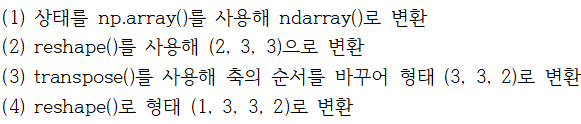

2. 추론

model.predict()로 추론을 수행하고, 결과를 취득한다. 인수 batch_size에 배치 사이즈 1을 지정한다.

3. 정책 취득

배치 사이즈는 1이므로 y[0][0]에 정책이 하나씩 출력된다. 여기에서 둘 수 있는 수만을 추출해 합계로 나누어 둘 수 있는 수만의 확률 분포로 변환한다.

4. 가치 취득

배치 사이즈가 1이므로 y[1][0]에 가치가 하나씩 출력된다. 가치의 배열로부터 값만을 추출하므로, y[1][0][0]으로 취득한다.

* 몬테카를로 트리 탐색 스코어 취득

'pv_mcts_socres(model, state, temperature)'는 현재 국면에 대한 둘 수 있는 수의 확률 분포를 표시한다.

인수는 모델, 상태, 온도 파라미터다.

1. 몬테카를로 트리 탐색 노드 정의

몬테카를로 트리 탐색의 노드는 관리를 쉽게 하기 위해 Node 클래스로 정리한다.

Node 클래스의 멤버 변수는 다음과 같다.

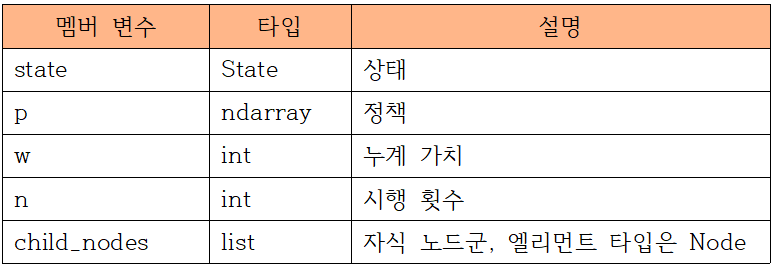

Node 클래스의 메소드는 다음과 같다.

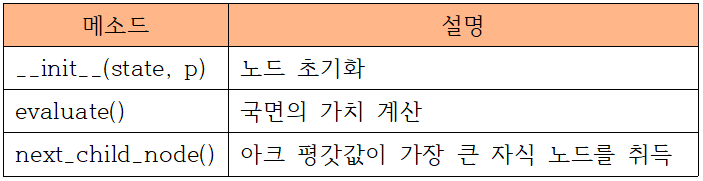


2. 현재 국면의 노드 생성

인수 state를 기반으로 현재 국면의 노드를 생성한다.

3. 여러 차례 평가를 실행

파라미터 'PV_EVALUATE_COUNT'의 횟수만큼 몬테카를로 트리 탐색 시뮬레이션을 실행한다. 그 결과, 시행 횟수가 높은 자식 노드가 가치가 높은 수가 된다.

4. 둘 수 있는 수의 확률 분포

'nodes_to_scores()'는 자식 노드의 리스트를 시행 횟수의 리스트로 변환한다. 이 리스트는 둘 수 있는 수의 확률 분포를 나타낸다. 뉴럴 네트워크는 입력이 같다면 출력도 같아진다. 때문에 이 둘 수 있는 수의 확률 분포를 사용해 셀프 플레이를 수행하면 같은 수만 두게 되므로 학습 데이터 변화에 변동(variation)이 늘어나지 않는다.

Sarsa나 Q 학습에서는 ε-greedy로 출력에 변화를 주었지만, 알파제로에서는 '볼츠만 분포'를 사용한다. 인수 'temperature'는 '온도 파라미터'라 불리는 볼츠만 분포의 분산된 정도를 지정한다.

온도 파라미터가 1인 경우는 시행 횟수가 가장 많은 수를 100% 선택하도록 최댓값만을 1이 되도록 하고 있다.

* 국면 가치 계산

다음 리스트의 'evaluate()'는 국면 가치를 계산한다.

1. 게임이 종료된 경우

게임이 종료된 경우에는 '패배: -1', '무승부: 0'을 반환한다. 이 때, 노드 누계 가치와 시행 횟수도 갱신한다.

2. 자식 노드군이 존재하지 않는 경우

게임이 종료되는 경우 이외에, 자식 노드군이 존재하지 않는 노드는 자식 노드를 전개할 수 있지만, 아직 전재하지 않은 노드다. 자시기 노드군이 존재하지 않는 경우에는 뉴럴 네트워크에서 추론을 수행하고, 정책과 가치를 취득한다.

이 때, 노드의 누계 가치와 시행 횟수도 갱신한다. 또한, 자식 노드군도 전개한다.

3. 자식 노드가 존재하는 경우

자식 노드군이 존재하는 경우(리프가 아닌 노드)는 아크 평갓값이 가장 큰 자식 노드의 평가를 재귀적으로 계산한다. 이 때, 노드의 누계 가치와 시행 횟수도 갱신. 또한, evaluate()의 가치는 상태 국면의 가치이므로 마이너스(-)를 붙인다.


* 볼츠만 분포에 따른 분산도 부가

'boltzman(xs, temperature)'는 볼츠만 분포를 계산한다. 인수는 둘 수 있는 수의 확률 분포와 온도 파라미터다. 둘 수 있는 수의 확률 분포에 분산을 부가한 값을 반환한다.

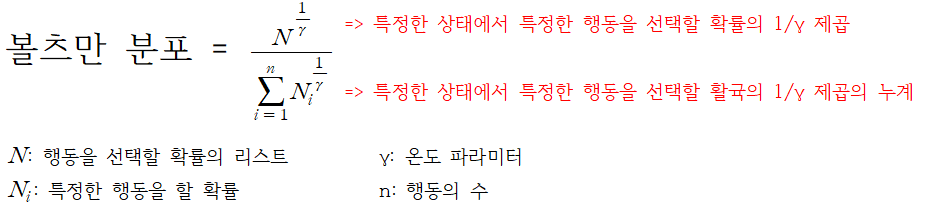

In [2]:
!dir

game.py  pv_mcts\ (1).py  pv_mcts.py  sample_data


In [8]:
# pv_mcts.py 얻로드
from google.colab import files
uploaded = files.upload()

# 폴더 확인
!dir

Saving pv_mcts.py to pv_mcts (2).py
dual_network.py  model		  pv_mcts\ (2).py  __pycache__
game.py		 pv_mcts\ (1).py  pv_mcts.py	   sample_data


In [4]:
!python game.py

-o-
---
---

-o-
---
--x

-o-
o--
--x

-o-
o--
x-x

-o-
oo-
x-x

-o-
oo-
xxx



In [5]:
!python dual_network.py

2021-04-14 08:29:51.242950: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-04-14 08:29:53.281456: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-14 08:29:53.306492: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-14 08:29:53.368038: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-04-14 08:29:53.368115: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3a839e21b4e2): /proc/driver/nvidia/version does not exist
2021-04-14 08:29:53.368670: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [9]:
!dir

dual_network.py  model		  pv_mcts\ (2).py  __pycache__
game.py		 pv_mcts\ (1).py  pv_mcts.py	   sample_data


In [11]:
!python pv_mcts\ \(2\).py

2021-04-14 08:43:28.731365: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-04-14 08:43:30.929078: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-14 08:43:30.930122: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-14 08:43:30.941059: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-04-14 08:43:30.941116: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3a839e21b4e2): /proc/driver/nvidia/version does not exist
2021-04-14 08:43:30.941687: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-14 08:43:31.775154: I tensorflow/compiler/mlir/mlir_graph_optimizati